# Abstract 

La posibilidad que brindan los sistemas automatizados de decision y clasificacion son sobresalientes al producir mejoras de producto y reducir costos o aumentar ganacias, de manera sistematica y eficaz. Muchas empresas relacionadas al juego y apuestas utilizan esto para predecir numeros ante la gran cantidad de datos que se nos brinda dados en el dataset. Asi mismo , el cliente propone una solucion practica ante las circunstacias economicas que atraviesa.

En base a esta informacion , se puede hacer una investigacion y resolver las practicas beneficiosas de los jugadores y del equipo en cada uno de los juegos, es decir , es posible hacer preguntas y responderlas para obtener nuevos conocimientos sobre los equipos, los jugadores y la competencia en sí. Por ejemplo, se puede analizar la tendencia de los equipos en casa y fuera de casa, las estadísticas de los jugadores en diferentes momentos del partido, o el porcentaje de victorias y derrotas de los equipos.

Este proyecto se basara en utilizar los datos disponibles para encontrar las diferencias y probrabilidades en cada partido dado durante los años jugados por la NBA. El objetivo se centrara en poder adquirir una variable que determine un numero en el cual se basara la cuota cobrada por el sistema de apuestas. Ademas , este analisis proovera al cliente con el gran beneficio del conocimiento y la ventaja por sobre la competencia , o hacia los mismos usuarios de la plataforma.

Asi, lo visto durante un analisis exploratorio de los datos y las caracteristicas del conjunto , se plantearan las primeras hipotesis para luego establecer un modelo predictivo de los datos de interes. Luego de un resultado final , se podra verificar el uso de las herramientas y las capacidades un sistema de ML.

# Entrenando un algoritmo de Machine Learning (Segunda parte)

Una de las bases del entrenamiento de un modelo se basa en las variables que se utilizaran para el mimso , la correlacion con la *variable Target* y la variabilidad de estas , seran determinantes a la hora de elegirlas.
Las variable existentes no muestran de manera directa la relacion de que **un equipo gane segun su comportamiento en temporadas pasadas/actual** . En estos casos , es sugerible realizar nuevas variables en el propio dataset que brinden nueva informacion y esta informacion demuestre la correlacion con las variable de interes

## Desarrollo del codigo

In [3]:
#Cargar librerias principales
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
# Suprimir las advertencias para futuros usos
warnings.filterwarnings("ignore")

## Feature Engenering: WIN_FACTOR

Para poder establecer que equipos poseen un mejor rendimiento o que poseen una mayor posibilidad de ganar , se decidio basarse en las cantidad de veces que gano y la cantidad de veces que gano consecutivamente (como se derrollo en la ultima entrega):

**WIN_SEASONS** : Cantidad de temporadas ganadas del equipo

**WIN_SEASONS_C** : Cantidad de temporadas ganadas consecutivas del equipo (Veces que sucedio)

Estas variables almacenaran los valores que se obtubieron en insights ya presentados

Hay que recordar que en analisis anterior se concluyo que:

Los puntajes en los equipos durante las temporadas es similar

Los equipos que ganaron alguna ves el campeonato tienen una mayor probabilidad de hacerlo nuevamente con respecto al azar

Los equipos que ganaron el campeonato actualmente , tendran una mayor probabilidad de hacerlo nuevamente el proximo año


In [3]:
# Se cargara el dataset de entrenamiento (el ds origianl = clean_games.csv) 
# y actualizara con los valores que queremos agregar (team_wins.csv)
os.chdir('D:/Documents/GitHub/NBA_games_analitycs/data')
ds_path='clean_games.csv'
df = pd.read_csv(ds_path)


# Define la codificación alfabética
equipos = {}
equipo_actual = 'A'

# Itera sobre las filas del DataFrame y realiza los cambios en las columnas HOME_TEAM_ID y VISITOR_TEAM_ID
for index, row in df.iterrows():
    home_team_id = row['TEAM_ID_home']
    visitor_team_id = row['TEAM_ID_away']
    
    # Verifica si el equipo ya está codificado, si no, le asigna una nueva letra
    if home_team_id not in equipos:
        equipos[home_team_id] = equipo_actual
        equipo_actual = chr(ord(equipo_actual) + 1)
    
    if visitor_team_id not in equipos:
        equipos[visitor_team_id] = equipo_actual
        equipo_actual = chr(ord(equipo_actual) + 1)
    
    # Actualiza los valores de los nombres de los equipos en las columnas correspondientes
    df.at[index, 'TEAM_ID_home'] = equipos[home_team_id]
    df.at[index, 'TEAM_ID_away'] = equipos[visitor_team_id]
#df.head()

In [191]:
#Datos que resumen los partidos y estadisticas anteriores
tw_path='team_wins.csv'
tw = pd.read_csv(tw_path)
tw

,SEASON,TEAM_ID,veces_consecutivas
0,2003,F,0
1,2004,E,0
2,2005,U,0
3,2006,E,0
4,2007,R,0
5,2008,[,1
6,2009,[,0
7,2010,U,0
8,2011,A,1
9,2012,A,0


Antes de modificar agregar las variables , sera necesario armar estructuras que permitan leer los datos de forma correcta y ordenada para poder hacer un analisis e insertado correspondiente de manera eficaz

In [180]:
#Registro necesario para la insercion de "WIN_SEASONS"

# Previo a continuar , modificaremos los nombres de las columnas para que no generen conflicto en los dataframe a usar
tw = tw.rename(columns={'TEAM_ID': 'WIN_SEASONS','veces_consecutivas':'WIN_SEASONS_C'})
# Crearemos un DataFrame para almacenar los valores acumulados por equipo y temporada
equipos = tw["WIN_SEASONS"].unique()
temporadas = tw["SEASON"].unique()
register = pd.DataFrame(columns=equipos, index=temporadas)
# Calcular los valores acumulados por equipo y temporada
for temporada in temporadas:
    for equipo in equipos:
        df_temp = tw[(tw["SEASON"] <= temporada) & (tw["WIN_SEASONS"] == equipo)]
        register.loc[temporada, equipo] = df_temp["WIN_SEASONS"].apply(len).sum()

register

,F,E,U,R,[,A,G,T,J,Z
2003,1,0,0,0,0,0,0,0,0,0
2004,1,1,0,0,0,0,0,0,0,0
2005,1,1,1,0,0,0,0,0,0,0
2006,1,2,1,0,0,0,0,0,0,0
2007,1,2,1,1,0,0,0,0,0,0
2008,1,2,1,1,1,0,0,0,0,0
2009,1,2,1,1,2,0,0,0,0,0
2010,1,2,2,1,2,0,0,0,0,0
2011,1,2,2,1,2,1,0,0,0,0
2012,1,2,2,1,2,2,0,0,0,0


In [181]:
#Registro necesario para la insercion de "WIN_SEASONS_C"

register_c= tw[tw['WIN_SEASONS_C'] == 1]
register_c.index=register_c['SEASON']
equipos = register_c['WIN_SEASONS'].unique()
temporadas = tw['SEASON'].unique()
register_c_ordered = pd.DataFrame(0, columns=equipos, index=temporadas)

# Iterar a través de las filas de 'ganadores' y aumentar en 1 el valor correspondiente en el nuevo DataFrame
for index, row in register_c.iterrows():
    equipo = row['WIN_SEASONS']
    temporada = row['SEASON']
    register_c_ordered.loc[temporada, equipo] += 1

# Acumular los valores en el nuevo DataFrame por temporada
register_c_ordered = register_c_ordered.cumsum()

register_c_ordered

,[,A,G,Z
2003,0,0,0,0
2004,0,0,0,0
2005,0,0,0,0
2006,0,0,0,0
2007,0,0,0,0
2008,1,0,0,0
2009,1,0,0,0
2010,1,0,0,0
2011,1,1,0,0
2012,1,1,0,0


In [183]:
# Agregamos las columnas necesarias para la variables
df['WIN_SEASONS']=None
df['WIN_SEASONS_C']=None
df['UT']=None
df['RR']=None
df['WIN_FACTOR']=None

Luego de armar las estructuras necesarias y modificar los espacios en el dataframe , seguira la insercion iterando en cada partido

In [184]:
# Insercion del registro "WIN_SEASONS" al dataframe

def obtener_valor_register(season,home_id,register):
    temp_2 = 0
    if home_id in register.columns:
        temp = register[home_id]
        temp_2 = temp[season]
    return temp_2


for match in range(len(df['WIN_SEASONS'])):
    season=int(df.iloc[match,df.columns.get_indexer(['SEASON'])].values)
    team=df.iloc[match ,df.columns.get_indexer(['TEAM_ID_home'])].values.item(0)
    temp = obtener_valor_register(season,team,register)
    df['WIN_SEASONS'][match] = temp

#3 min de ejecucion

In [185]:
# Insercion del registro "WIN_SEASONS_C" al dataframe

def obtener_WIN_SEASON_C(season,home_id,register):
    temp_2=0
    if season in register.index:
        temp=register.loc[season]
        if home_id in temp:
            temp_2=temp[home_id]
    return temp_2

for match in range(len(df['WIN_SEASONS_C'])):
    season=int(df.iloc[match,df.columns.get_indexer(['SEASON'])].values)
    team=df.iloc[match ,df.columns.get_indexer(['TEAM_ID_home'])].values.item(0)
    temp = obtener_WIN_SEASON_C(season,team,register_c_ordered)
    df['WIN_SEASONS_C'][match] = temp

df
#3 min de ejecucion

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,WIN_SEASONS,WIN_SEASONS_C,UT,RR,WIN_FACTOR
0,2022-03-12,22101005,Final,2021,A,104.0,0.398,0.760,0.333,23.0,...,0.875,0.357,21.0,46.0,0,2,1,None,None,None
1,2022-03-12,22101006,Final,2021,C,101.0,0.443,0.933,0.429,20.0,...,0.824,0.208,19.0,40.0,1,0,0,None,None,None
2,2022-03-12,22101007,Final,2021,E,108.0,0.412,0.813,0.324,28.0,...,1.000,0.389,23.0,47.0,0,3,0,None,None,None
3,2022-03-12,22101008,Final,2021,G,122.0,0.484,0.933,0.400,33.0,...,0.696,0.386,27.0,39.0,1,3,2,None,None,None
4,2022-03-12,22101009,Final,2021,I,115.0,0.551,0.750,0.407,32.0,...,0.760,0.387,28.0,50.0,0,0,0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2014-10-06,11400007,Final,2014,P,93.0,0.419,0.821,0.421,24.0,...,0.643,0.375,17.0,43.0,1,0,0,None,None,None
25693,2014-10-06,11400004,Final,2014,C,81.0,0.338,0.719,0.381,18.0,...,0.636,0.267,17.0,47.0,0,0,0,None,None,None
25694,2014-10-06,11400005,Final,2014,[,98.0,0.448,0.682,0.500,29.0,...,0.659,0.500,19.0,43.0,1,2,1,None,None,None
25695,2014-10-05,11400002,Final,2014,J,99.0,0.440,0.771,0.333,21.0,...,0.725,0.385,18.0,45.0,1,0,0,None,None,None


Ya definidas las variables de interes , se procedera a realizar un modelo que realice la prediccion de un valor de importancia (o peso) , es decir , se **realizara una variable muestre un factor de "ganador"**

**WIN_FACTOR** : Factor que muestra posibilidad de ganar del equipo

Lo que se intenta con esta variable es poder modificar la variable target durante el primer cuarto de un partido, para que el modelo tenga una mayor precision al inicio del mismo , ya que al tener pocos datos (datos que se recopilan en tiempo real) el modelo podria estar dando un valor de cuota erroneo totalmente en los primeros 12 minutos.

Para estimar el valor de una variable acorde de probabilidad (entre 0 y 1) , se usara el anterior desarrollo de proporciones de las situaciones a favor en las que ganaron los equipos:

In [186]:
# Cantidad de equipos que participan en la temporada para estimar una probabilidad clasica de que cada equipo sea victorioso
n_equipos = 60
p_equipos = 1/n_equipos
print(f'La probabilidad clasica de ganar es de :',round(p_equipos,2))

# Cantidad de veces que hubo victorias consecutivas, temporadas en las que se produjo un caso y la proporcion de casos
ganadas_consecutivas = 5
temporadas_consecutivas = 19
equipos_consecutivas = 4
proporcion_consecutivas = ganadas_consecutivas/(temporadas_consecutivas*equipos_consecutivas)
print(f'La proporcion de ganadas consecutivas por equipo es de :',round(proporcion_consecutivas,2))

# Cantidad de veces que hubo victorias individuales, temporadas en las que se pudo producir un caso y la proporcion de casos
ganadas_individuales = 13 # No consecutivas
equipos_individuales = 7  # Equipos que ganaron una temporada sin ser una consecutiva
temporadas_individuales = 20
proporcion_individuales = ganadas_individuales/(temporadas_individuales*equipos_individuales)
print(f'La proporcion de ganadas individuales por equipo es de :',round(proporcion_individuales,2))

La probabilidad clasica de ganar es de : 0.02
La proporcion de ganadas consecutivas por equipo es de : 0.07
La proporcion de ganadas individuales por equipo es de : 0.09


Asi  podemos estimar de manera discreta , que la posibilidad de ganar de un equipo que gano al menos una ves es del 7% y la probabilidad de ser victorioso porque gano la temporada anterior es de un 9%
Para el ultimo caso , la probabilidad es condicional debido a que es necesario que gane la temporada actual (y eso tiene una probabilidad asociada).Asi , se tomaran 3 casos para estimar las bases:

**Si el equipo no gano ninguna temporada hasta ahora , se considerara como una situacion normal en la que tiene la misma posibilidad de ganar que los demas , es decir, 2%**

**Si el equipo gano al menos una temporada hasta ahora, se considerara una probabilidad mayor a la situacion normal , que deberia ser la que el equipo es de mejor rendimiento que la mayoria , es decir , la probabilidad estadistica + la probabilidad por ser un "equipo de mejor rendimiento" , 2% + 7% = 9%**

**Si el equipo gano la ultima temporada, se considera que el equipo es de mayor rendimiento que la mayoria y que existe la posibilidad de continuar la racha por "un mejor estado del equipo" demostrado en la ultima temporada: 2% + 7% + 9% = 18%**

Teniendo las bases para las condiciones , se puede establecer la ecuacion con los parametros ajustados a un valor apropiado:

* PC= Probabilidad estadistica : [1 equipo]/[N de equipos]

* PGC = Probabilidad por estado : [Victorias consecutivas de equipos]/[Temporada consecutivas de equipos * N de equipos que ganaron consecutivamente]

* PGI = Probabilidad por rendimiento y club : [Victorias individuales de equipos]/[Temporada individuales de equipos * N de equipos que ganaron al menos una ves]

WF = PC + PGC + PGI 

Como estimacion por puntaje , presenta un valor aceptable pero el tiempo es parte del efecto de estas posibilidades, por lo tanto , sera necesario tomar algunos parametros extra para ajustar aun mejor la variable.

WF = PC + PGC x UT + PGI x RR

**UT (Ultima Temporada)** = Parametro binario que determina si gano o no la ultima temporada : [ 1 | 0 ]

**RR (Rendimiento Reciente)** = Parametro que determina en que medida se puede estimar el rendimiento de un equipo debido a las ganadas de las temporadas anteriores : [Numero de temporada victoriosas de cada equipo] / [Numero de temporada totales que participo el equipo]

De esta manera es posible parametrizar el peso de cada situacion que genera una adicion de probabilidad a ganar. Estas variables son partes de los datos de modificacion del valor de "WIN_FACTOR" , por lo tanto sera necesario "insertarlas" de la misma manera que las variables anteriores.

In [224]:
# Insercion del registro "UT" al dataframe

def obtener_UT(season,home_id,tw_r):
    temp_2=0
    #register_season=register['SEASON'].apply(pd.to_numeric)
    if season >= 2004:
        if tw_r[(tw_r['SEASON'] == season) & (tw_r['TEAM_ID'] == home_id)].shape>(0,3):
        #if register[register['SEASON']==season and register['WIN_SEASONS']==home_id].exists():
            temp_2=1
    return temp_2

tw['SEASON'] = tw['SEASON'].apply(pd.to_numeric)

for match in range(len(df['WIN_SEASONS'])):
    season=int(df.iloc[match,df.columns.get_indexer(['SEASON'])].values)
    team=df.iloc[match ,df.columns.get_indexer(['TEAM_ID_home'])].values.item(0)
    temp=None
    temp = obtener_UT(season,team,tw)
    df['UT'][match] = temp

#3 min de ejecucion

In [243]:
# Insercion del registro "RR" al dataframe

def obtener_RR(season,home_id,register):
    temp_2=0
    if season >= 2004 and season in register.index:
        temp=register.loc[season-1]
        if home_id in temp:
            temp_2=temp[home_id]/(season-2003)
    return temp_2

for match in range(len(df['WIN_SEASONS'])):
    season=int(df.iloc[match,df.columns.get_indexer(['SEASON'])].values)
    team=df.iloc[match ,df.columns.get_indexer(['TEAM_ID_home'])].values.item(0)
    temp = obtener_RR(season,team,register)
    df['RR'][match] = temp

#Debido a un error en los datos del dataframe (en la temporada de 2014) corregiremos el error de 'RR' en este periodo
df['RR'] = df['RR'].mask(df['RR']==1, np.median)

#3 min de ejecucion
df

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,WIN_SEASONS,WIN_SEASONS_C,UT,RR,WIN_FACTOR
0,2022-03-12,22101005,Final,2021,A,104.0,0.398,0.760,0.333,23.0,...,0.875,0.357,21.0,46.0,0,2,1,0,0.111111,0.018934
1,2022-03-12,22101006,Final,2021,C,101.0,0.443,0.933,0.429,20.0,...,0.824,0.208,19.0,40.0,1,0,0,0,0.000000,0.016667
2,2022-03-12,22101007,Final,2021,E,108.0,0.412,0.813,0.324,28.0,...,1.000,0.389,23.0,47.0,0,3,0,0,0.166667,0.021769
3,2022-03-12,22101008,Final,2021,G,122.0,0.484,0.933,0.400,33.0,...,0.696,0.386,27.0,39.0,1,3,2,0,0.166667,0.021769
4,2022-03-12,22101009,Final,2021,I,115.0,0.551,0.750,0.407,32.0,...,0.760,0.387,28.0,50.0,0,0,0,0,0.000000,0.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2014-10-06,11400007,Final,2014,P,93.0,0.419,0.821,0.421,24.0,...,0.643,0.375,17.0,43.0,1,0,0,0,0.000000,0.016667
25693,2014-10-06,11400004,Final,2014,C,81.0,0.338,0.719,0.381,18.0,...,0.636,0.267,17.0,47.0,0,0,0,0,0.000000,0.016667
25694,2014-10-06,11400005,Final,2014,[,98.0,0.448,0.682,0.500,29.0,...,0.659,0.500,19.0,43.0,1,2,1,0,0.181818,0.020377
25695,2014-10-05,11400002,Final,2014,J,99.0,0.440,0.771,0.333,21.0,...,0.725,0.385,18.0,45.0,1,0,0,0,0.000000,0.016667


Finalmente , atraves del analisis de cada fila que contiene los datos de cada partido , se determinara el valor de WIN_FACTOR

In [244]:
# Insercion de "WIN_FACTOR"

def obtener_WIN_FACTOR (pc,pgc,ut,pgi,rr):
    wf_actual=pc+pgc*ut+pgi*rr
    return wf_actual

for match in range(len(df.index)):
    pc=1/n_equipos
    pgc=int(df.iloc[match,df.columns.get_indexer(['WIN_SEASONS_C'])].values)/(len(register_c.index)*len(register_c.columns))
    pgi=int(df.iloc[match,df.columns.get_indexer(['WIN_SEASONS'])].values)/((len(register.index)-len(register_c.index))*(len(register.columns)-len(register_c.columns)))
    ut=int(df.iloc[match,df.columns.get_indexer(['UT'])].values)
    rr=float(df.iloc[match,df.columns.get_indexer(['RR'])].values)
    wf = obtener_WIN_FACTOR(pc,pgc,ut,pgi,rr)
    df['WIN_FACTOR'][match] = wf

df

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,WIN_SEASONS,WIN_SEASONS_C,UT,RR,WIN_FACTOR
0,2022-03-12,22101005,Final,2021,A,104.0,0.398,0.760,0.333,23.0,...,0.875,0.357,21.0,46.0,0,2,1,0,0.111111,0.018934
1,2022-03-12,22101006,Final,2021,C,101.0,0.443,0.933,0.429,20.0,...,0.824,0.208,19.0,40.0,1,0,0,0,0.000000,0.016667
2,2022-03-12,22101007,Final,2021,E,108.0,0.412,0.813,0.324,28.0,...,1.000,0.389,23.0,47.0,0,3,0,0,0.166667,0.021769
3,2022-03-12,22101008,Final,2021,G,122.0,0.484,0.933,0.400,33.0,...,0.696,0.386,27.0,39.0,1,3,2,0,0.166667,0.021769
4,2022-03-12,22101009,Final,2021,I,115.0,0.551,0.750,0.407,32.0,...,0.760,0.387,28.0,50.0,0,0,0,0,0.000000,0.016667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25692,2014-10-06,11400007,Final,2014,P,93.0,0.419,0.821,0.421,24.0,...,0.643,0.375,17.0,43.0,1,0,0,0,0.000000,0.016667
25693,2014-10-06,11400004,Final,2014,C,81.0,0.338,0.719,0.381,18.0,...,0.636,0.267,17.0,47.0,0,0,0,0,0.000000,0.016667
25694,2014-10-06,11400005,Final,2014,[,98.0,0.448,0.682,0.500,29.0,...,0.659,0.500,19.0,43.0,1,2,1,0,0.181818,0.020377
25695,2014-10-05,11400002,Final,2014,J,99.0,0.440,0.771,0.333,21.0,...,0.725,0.385,18.0,45.0,1,0,0,0,0.000000,0.016667


A partir de estas variables agregadas es posible realizar un modelo que las relacione y realice una prediccion para cada partido.
Se procedera a armar el dataset con las variables y organizarlo correctamente para que el modelo pueda ser entrenado.

In [245]:
#Guardado de dataset con las variables agregadas
#df.to_csv('plus_games.csv', index=False)

In [5]:
# Carga de dataframe
#os.chdir('D:/Documents/GitHub/NBA_games_analitycs/data')
#ds_path='plus_games.csv'
#df = pd.read_csv(ds_path)

Para cerrar esta seccion mostraremos algunas graficas que representen la importancia de "WIN_FACTOR" como variable. Un ejemplo podria ser la correlacion entre esta variable y los puntos acumulados por equipo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


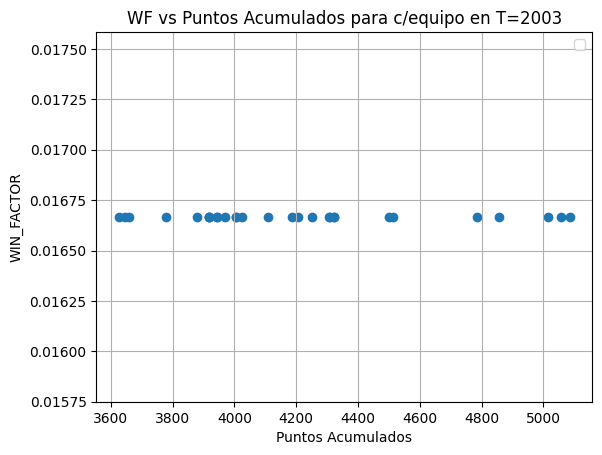

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


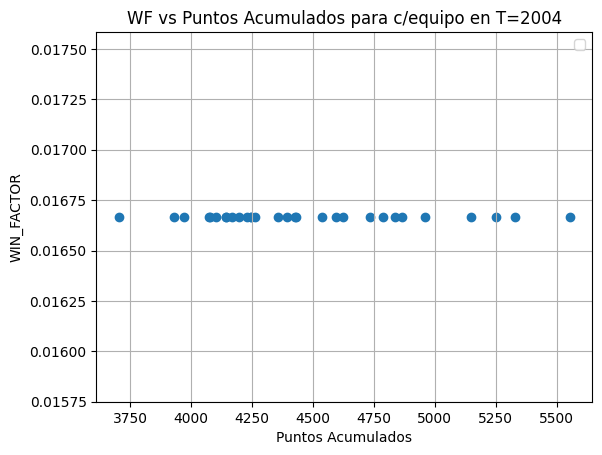

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


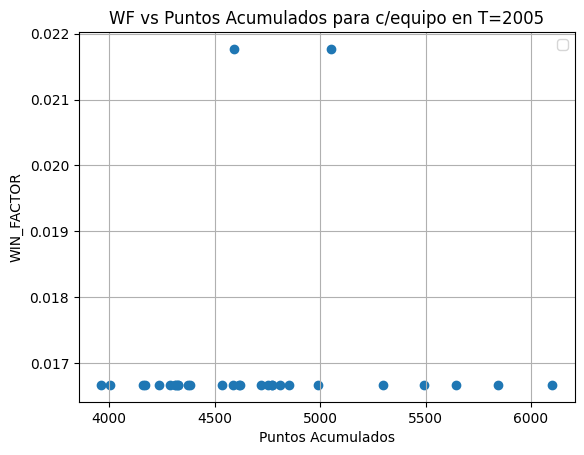

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


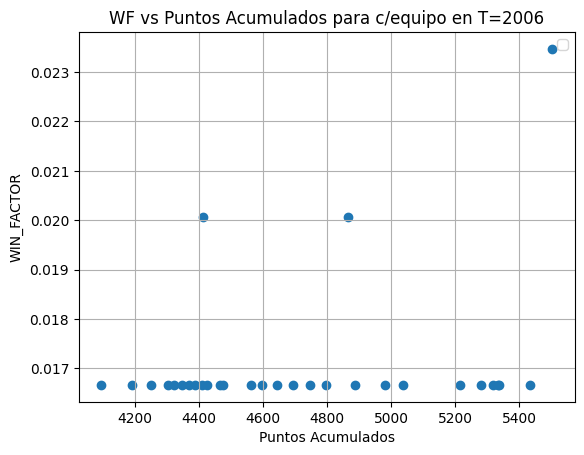

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


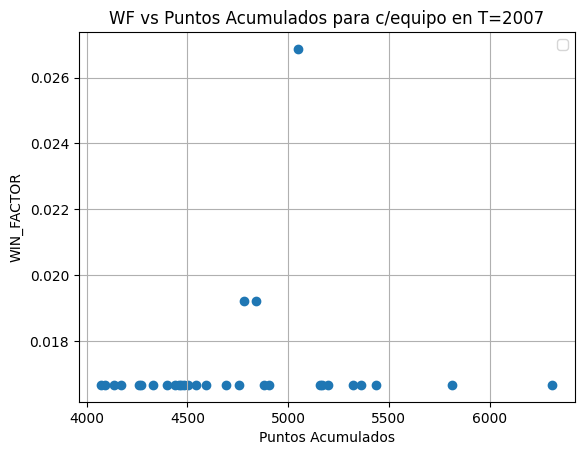

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


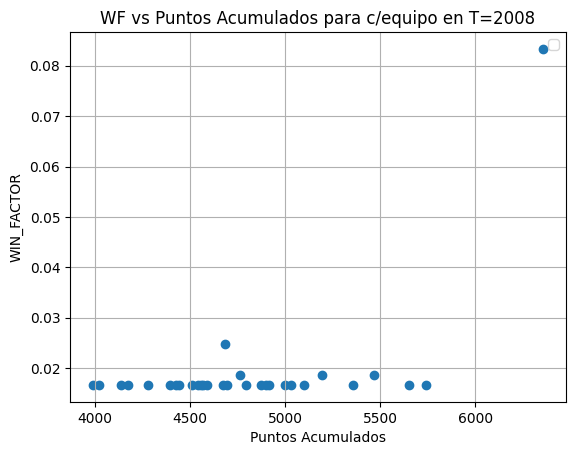

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


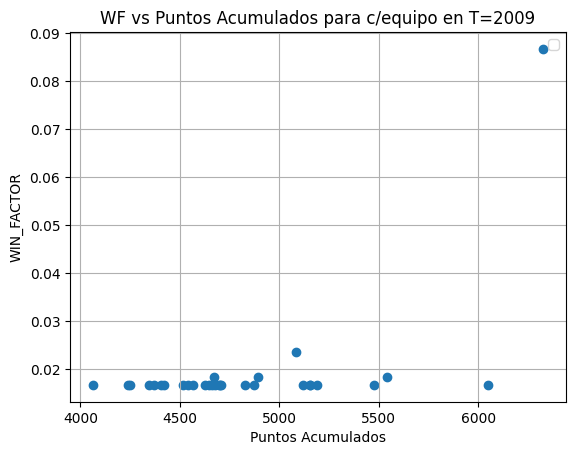

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


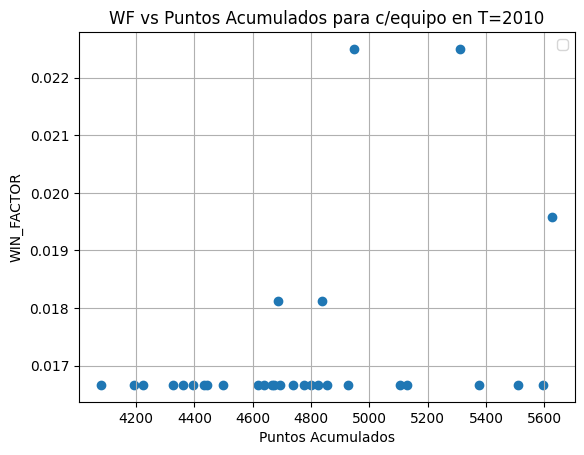

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


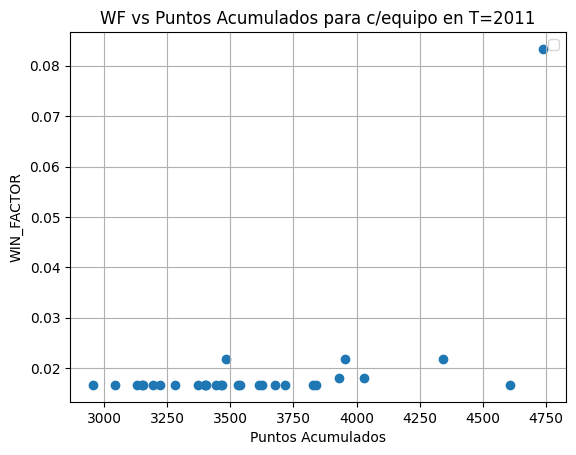

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


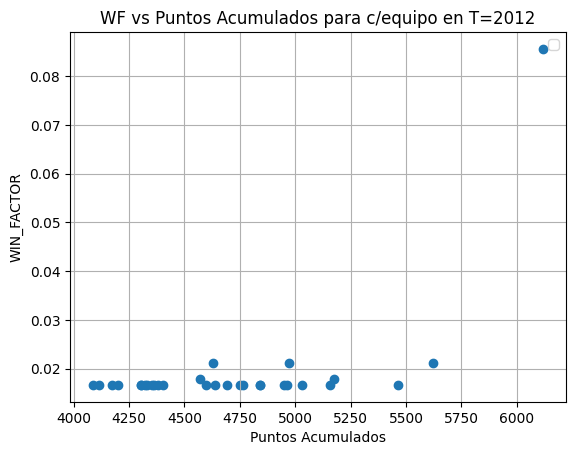

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


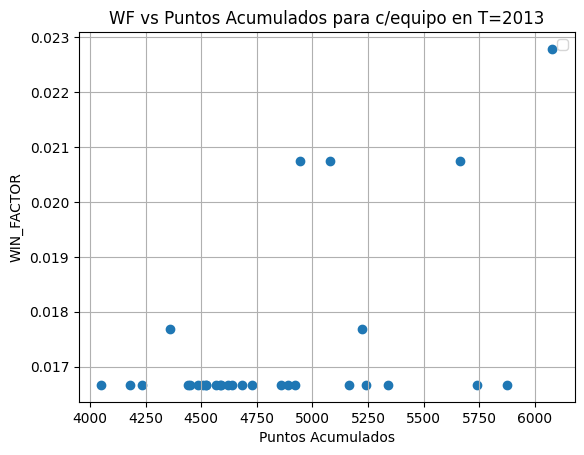

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


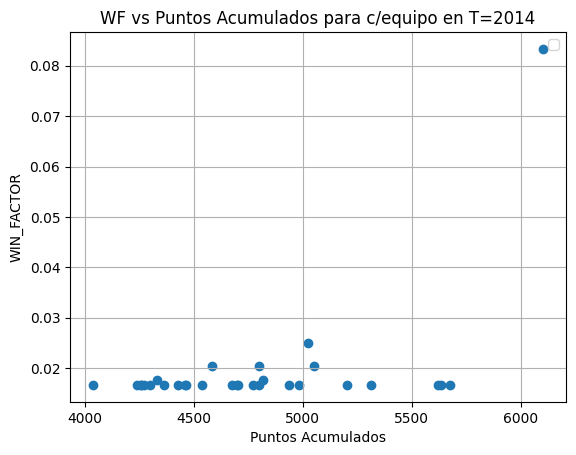

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


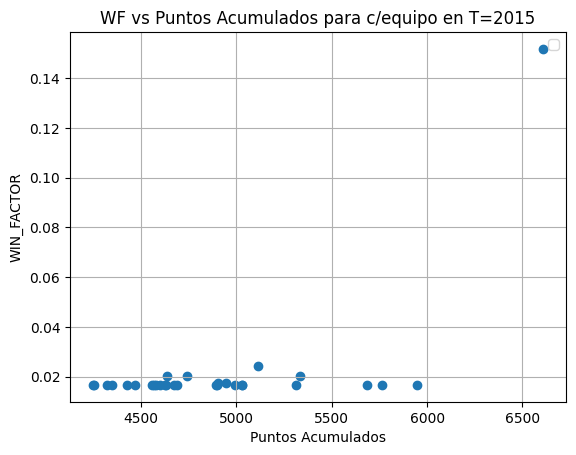

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


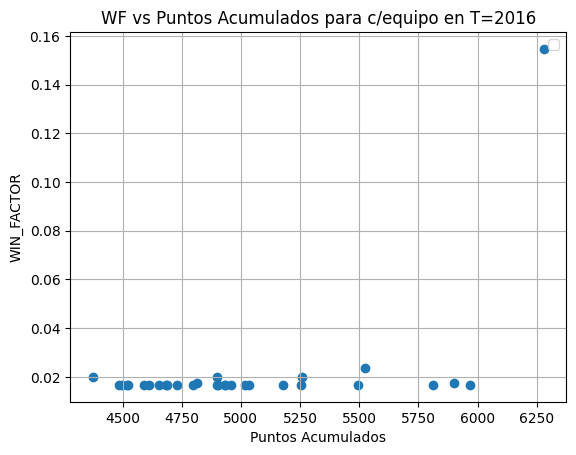

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


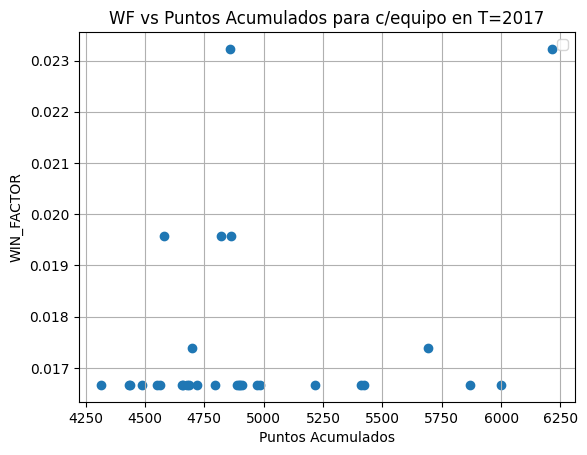

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


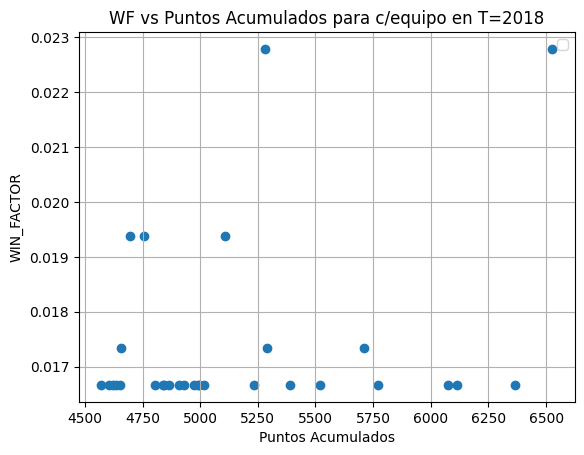

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


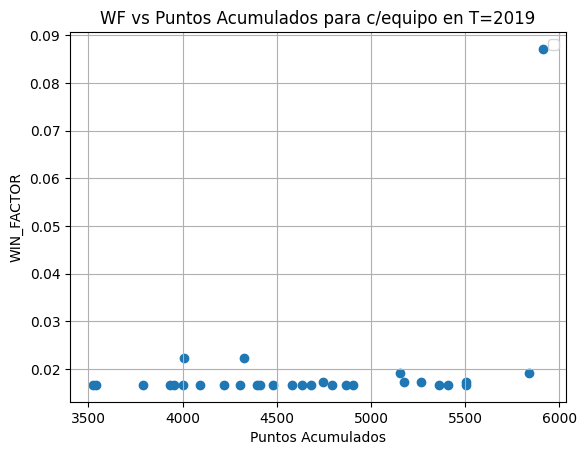

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


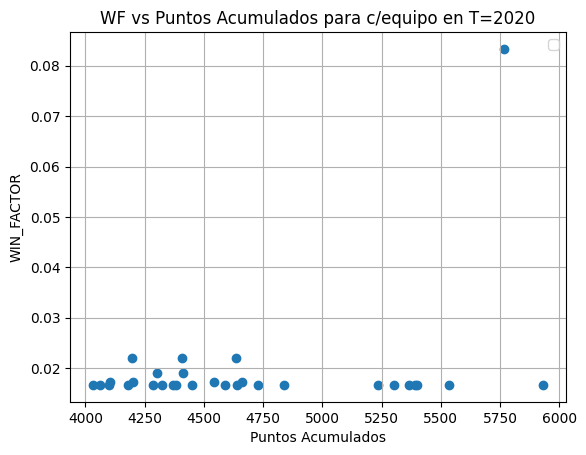

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


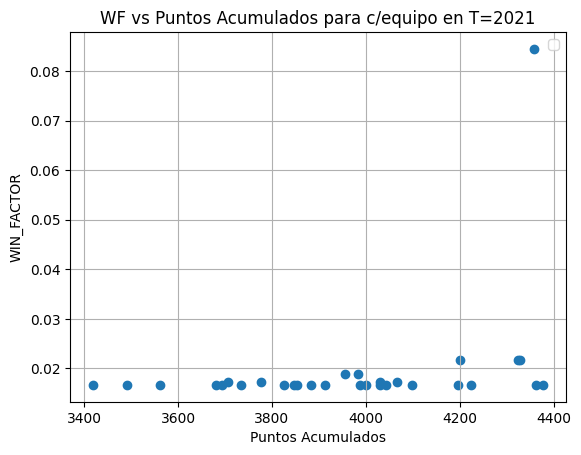

In [51]:
# Agrupar por temporada y equipo, y calcular la suma de puntos acumulados
season_points = df.groupby(['SEASON', 'TEAM_ID_home','WIN_FACTOR'])['PTS_home'].sum().reset_index()

# Graficar la relación entre 'Puntos Acumulados' y 'Variable a Graficar'
for temporada in season_points['SEASON'].unique():
    equipo_data = season_points[season_points['SEASON']==temporada]
    #equipo_data = equipo_data[equipo_data['TEAM_ID_home'] == equipo]
    plt.scatter(equipo_data['PTS_home'], equipo_data['WIN_FACTOR'])
    plt.xlabel('Puntos Acumulados')
    plt.ylabel('WIN_FACTOR')
    plt.title(f'WF vs Puntos Acumulados para c/equipo en T={temporada}')
    plt.legend()
    plt.grid(True)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


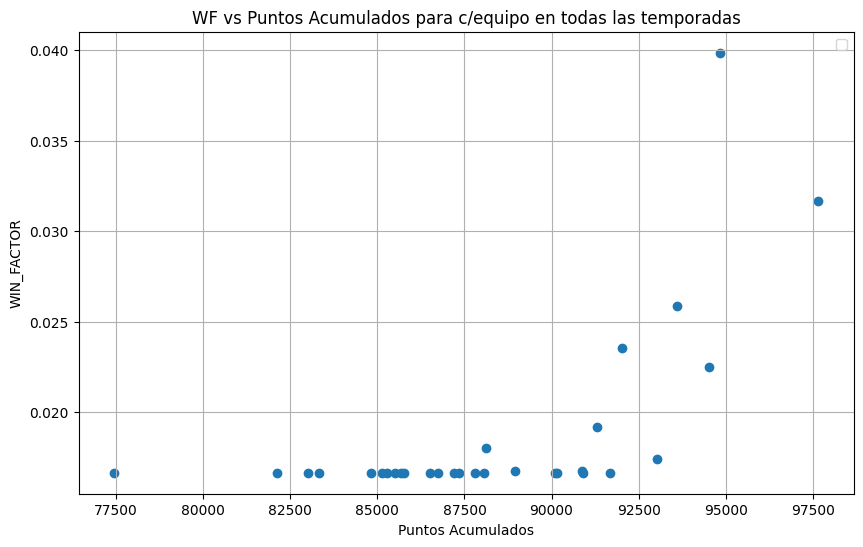

In [18]:
season_points_all = df.groupby('TEAM_ID_home')['PTS_home'].sum()
wf_all = df.groupby('TEAM_ID_home')['WIN_FACTOR'].mean()

# Crear un gráfico de dispersión para mostrar la relación

plt.figure(figsize=(10, 6))
plt.scatter(season_points_all, wf_all)
plt.xlabel('Puntos Acumulados')
plt.ylabel('WIN_FACTOR')
plt.title(f'WF vs Puntos Acumulados para c/equipo en todas las temporadas')
plt.legend()
plt.grid(True)

In [26]:
conc_points = pd.DataFrame()
conc_points['season_points_all']=season_points_all
conc_points['wf_all']=wf_all
conc_points.sort_values(by='season_points_all', ascending=False)

,season_points_all,wf_all
TEAM_ID_home,,
[,97664.0,0.031665
G,94826.0,0.039858
E,94525.0,0.022497
A,93607.0,0.025897
R,93026.0,0.017440
Z,92036.0,0.023563
I,91680.0,0.016667
U,91305.0,0.019210
^,90914.0,0.016667


Como se ve en la tabla y en los graficos , los equipos con mayores puntajes suelen tener valores mayores en "WIN_FACTOR" (visualizandose mejor en la grafica que contiene todas las temporadas), verificado por la tabla con sus valores.

## Entrenamiento de Algoritmo de ML

Con las nuevas variables agregadas al dataframe , sera posible entrenar un nuevo modelo que pueda estimar el valor de WIN_FACTOR tomando como base la informacion de las demas variables.
La razon de tener la prediccion de WIN_FACTOR es debido a que nos interesa tener una referencia mas "discreta" del rendimiento de los equipos. 
Existen variedad de maneras para poder hacer un entrenamiento correcto y que determine una probabilidad de ganar

Como regla general , es necesario usar la **Logistic_Reggression** para encontrar el valor de pobrabilidad , ya que los valores de decision de si gana o no son discretos (1|0). Asi, podremos armar distintos desarrollos que colaboren a un valor distinto debido al orden de las desiciones.
La organizacion en la presentacion de informacion entre datos es un factor fundamental para la correlacion de las variables y posible prediccion. Por lo tanto, ante la falta de veracidad en los resultados finales , se realizaran dos escenarios:

* **Modelo principal con "WIN_FACTOR" como feature adicional"** : La idea de que "WF" se comporte como una variable mas , traera una certeza al modelo desde el inicio del partido , dando la posibilidad de un valor mas regular desde el principio

* **Modelo principal ensamblado con modelo ponderado (Bagging)** : "WF" podria pertencer a un modelo distinto que prediga las posibilidades o no de ganar en base a su valor y ensamblarse con el modelo principal ya usado.

En el segundo caso , se podrian usar parametros para que el peso en el valor entregado por el modelo ponderado sea mas gradual durante la serie de tiempo

Para continuar , se propondra realizar el "Modelo ponderado" de manera que este pueda predecir el valor de la probabilidad de ganar unicamente con el valor de WIN_FACTOR
